# Fine-tuning the modified model with our data

## Imports


In [1]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torchvision
import numpy as np
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim
import time
import copy
import torchvision.transforms as transforms
from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import sys
sys.path.append('/content/drive/MyDrive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor, Normalize

## Helper functions

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [72]:
def meshgrid2d(B, Y, X, stack=False, device='cuda'):
    # returns a meshgrid sized B x Y x X

    grid_y = torch.linspace(0.0, Y-1, Y, device=torch.device(device))
    grid_y = torch.reshape(grid_y, [1, Y, 1])
    grid_y = grid_y.repeat(B, 1, X)

    grid_x = torch.linspace(0.0, X-1, X, device=torch.device(device))
    grid_x = torch.reshape(grid_x, [1, 1, X])
    grid_x = grid_x.repeat(B, Y, 1)

    if stack:
        # note we stack in xy order
        # (see https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.grid_sample)
        grid = torch.stack([grid_x, grid_y], dim=-1)
        return grid
    else:
        return grid_y, grid_x

def get_normalised_grid(N, B, H, W):
  N_ = np.sqrt(N).round().astype(np.int32)
  grid_y, grid_x = meshgrid2d(B, N_, N_, stack=False, device='cuda')
  grid_y =  grid_y.reshape(B, -1)/float(N_-1) * (H-16)
  grid_x =  grid_x.reshape(B, -1)/float(N_-1) * (W-16)

  # normalise to values of range [-1, 1] - x = -1, y = -1 is the left-top pixel
  grid_x = (grid_x - W) / W 
  grid_y = (grid_y - H) / H
  xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
  xy = xy.view(B, N_, N_, 2)

  return xy

In [71]:
import matplotlib.pyplot as plt

def show_predictions(pred_coords, true_coords):
  pred_coords = pred_coords.cpu().detach().numpy()
  true_coords = true_coords.cpu()

  plt.scatter(true_coords[:, 0], true_coords[:, 1], s=0.5, marker='.')
  plt.ylim(max(plt.ylim()), min(plt.ylim()))
  plt.title('True Coords')
  plt.pause(0.001)  # pause a bit so that plots are updated
  
  pred_x = pred_coords[:, 0]
  pred_y = pred_coords[:, 1]
  plt.scatter(pred_x, pred_y, s=0.5, marker='.')
  plt.ylim(max(plt.ylim()), min(plt.ylim()))
  # plt.ylim(360, 0)
  # plt.xlim(0, 640)
  plt.title('Predicted Coords')
  plt.pause(0.001)  # pause a bit so that plots are updated

## Our prediction model

In [5]:
def initialise_model(device):
  # Initialize model with the best available weights
  # create an instance of (e.g.) torchvision.models.segmentation.fcn_resnet50
  # and tell it to load pretrained weights
  weights = FCN_ResNet50_Weights.DEFAULT
  modified_model = fcn_resnet50(weights=weights)

  # we are feature extracting so we only need to compute weights for the new layer
  set_parameter_requires_grad(modified_model, True)

  # modify that model by removing its final layer and replacing with a 2D vector output at each pixel(?) (instead of 20 class logits)
  # instead of torch.Size([1, 21, 120, 240]) -> torch.Size([1, 2, 120, 240])
  modified_model.classifier[3] = nn.Sequential()
  modified_model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
  # print(modified_model)

  # model to train() and load onto computation devicce
  modified_model.to(device)

  return modified_model

### Train function

In [73]:
# define train function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_aux=False):
  model.to(device)
  since = time.time()

  val_loss_history = []

  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(0,num_epochs):
        if epoch%10==0 or epoch==num_epochs-1:
          print('-' * 10)
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            total_samples=0

            # Iterate over data.
            for i_batch, sample_batched in enumerate(dataloaders[phase]):
              batch_size = len(sample_batched['id'])
              total_samples+=batch_size

              inputs = sample_batched['image0']
              coords = sample_batched['coords'] 

              inputs = inputs.to(device).float() #torch.Size([B, 3, 120, 240])
              coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
              
              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs) # torch.Size([B, 2, H, W]) same as inputs shape
                    outputs = outputs['out']

                    # take the values of outputs from the NxN grid points
                    grid = get_normalised_grid(coords.shape[2], batch_size, outputs.shape[2], outputs.shape[3]) # ([B, H(64), W(64), 2])
                    outputs = torch.nn.functional.grid_sample(outputs, grid) # torch.size([B,2,H,W])

                    # reshape to match coords shape
                    outputs = torch.permute(outputs, (0, 2, 3, 1)) # torch.Size([B, H, W, 2])
                    outputs = outputs.view(batch_size,1,-1,2) # torch.Size([B, 1, 120*240, 2])
                    # coords = coords.view(batch_size, outputs.shape[1], outputs.shape[2], 2) # torch.Size([B, H, W, 2])

                    loss = criterion(outputs, coords)
                    _, preds = torch.max(outputs, 1)

                    if batch_size==1 and (epoch%10==0 or epoch==num_epochs-1):
                      show_predictions(outputs.squeeze(), coords.squeeze())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)

            if total_samples != 0:
              epoch_loss = running_loss / total_samples
              if epoch%10==0 or epoch==num_epochs-1:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if epoch == 0:
                best_loss = epoch_loss
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

            
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  # print('Best val loss: {:4f}\n'.format(best_loss))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_loss_history




## Initializing Datasets and Dataloaders

In [53]:
# Load dataset

TRAIN_DATA = "one_sample_2023-01-18"
# !unzip -d "$TRAIN_DATA"/ /content/drive/MyDrive/"$TRAIN_DATA".zip # unziping training data

dataset = TaiChiDataset(log_file=TRAIN_DATA+'/sample_ids.txt',
                        root_dir=TRAIN_DATA,
                        check=True,
                        transform=transforms.Compose([
                                               ToTensor(),
                                               Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                        ]))
print(len(dataset))

1


In [8]:
def split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed):
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
  validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

  return train_loader, validation_loader

## Training & evaluating the model

In [74]:
# set computation device
device = torch.device('cuda')

# initialise model
modified_model = initialise_model(device)

# see what parameters will be tuned
params_to_update = modified_model.parameters()
print('Params to learn:')
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

# print(modified_model)

Params to learn:
classifier.4.weight
classifier.4.bias


----------
Epoch 0/499
----------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


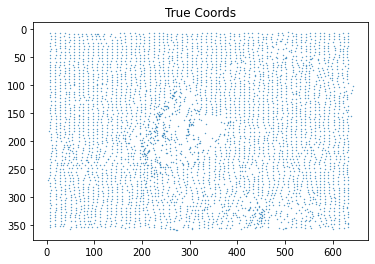

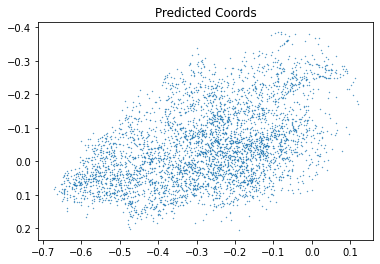

train Loss: 88948.5469
----------
Epoch 10/499
----------


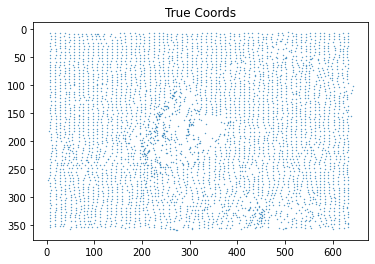

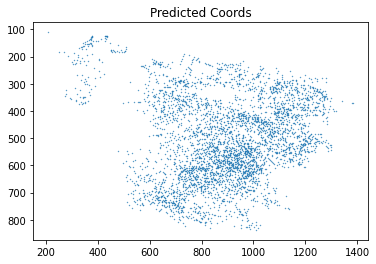

train Loss: 233625.6250
----------
Epoch 20/499
----------


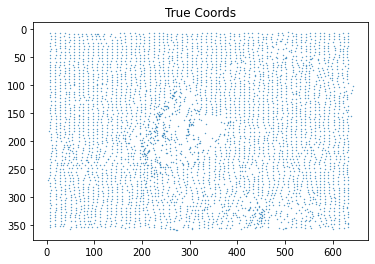

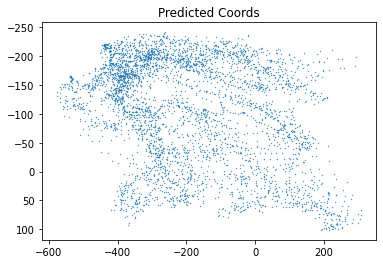

train Loss: 178952.5312
----------
Epoch 30/499
----------


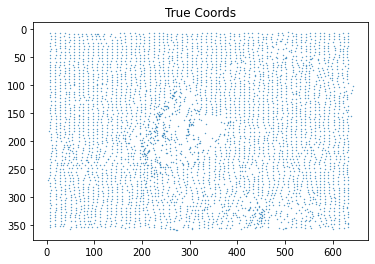

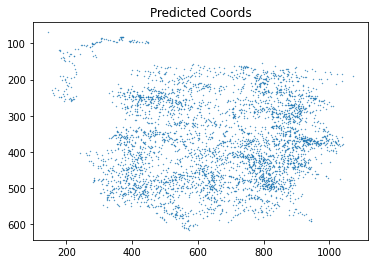

train Loss: 81360.0078
----------
Epoch 40/499
----------


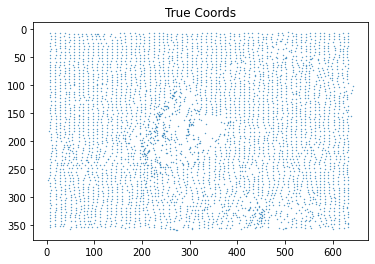

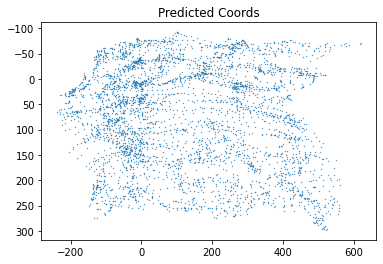

train Loss: 25147.5156
----------
Epoch 50/499
----------


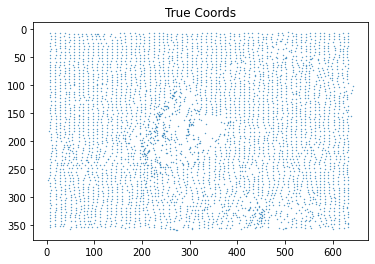

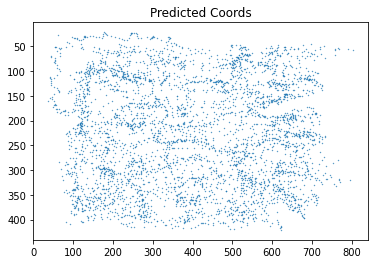

train Loss: 5315.0039
----------
Epoch 60/499
----------


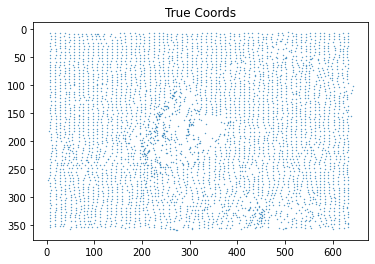

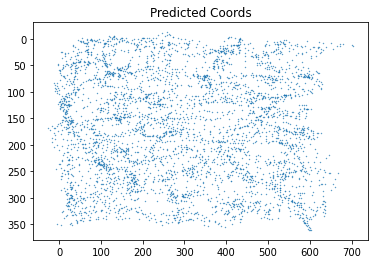

train Loss: 1002.3691
----------
Epoch 70/499
----------


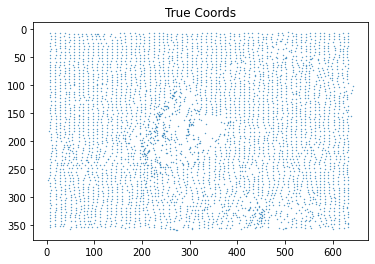

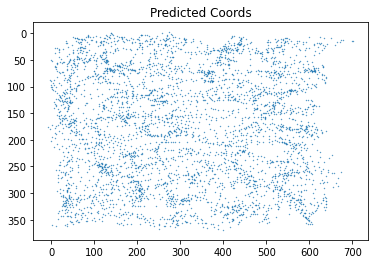

train Loss: 662.8966
----------
Epoch 80/499
----------


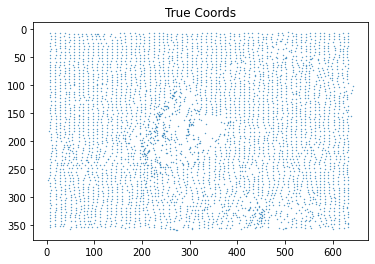

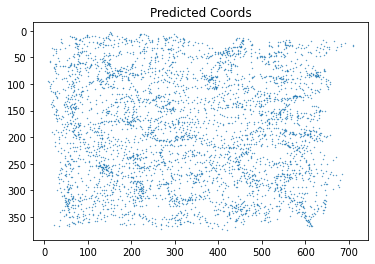

train Loss: 728.3093
----------
Epoch 90/499
----------


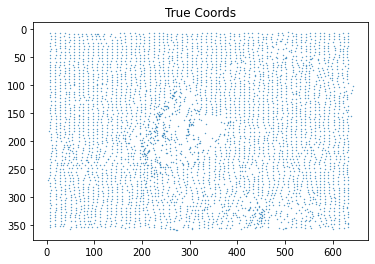

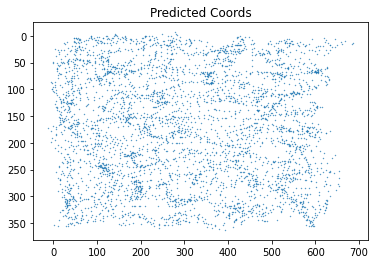

train Loss: 680.5717
----------
Epoch 100/499
----------


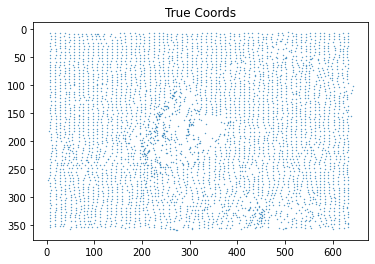

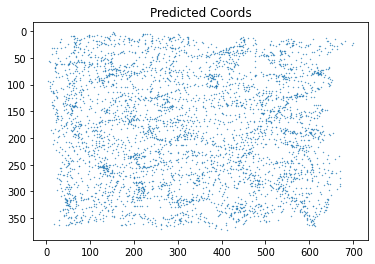

train Loss: 602.3068
----------
Epoch 110/499
----------


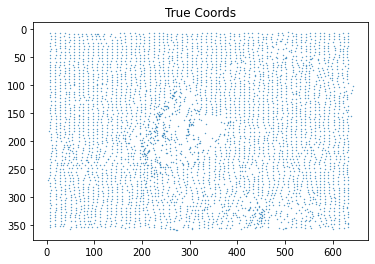

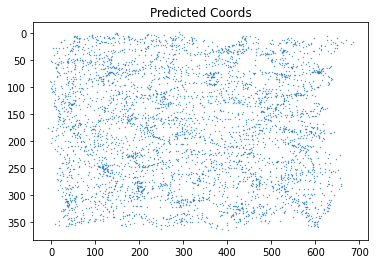

train Loss: 549.6414
----------
Epoch 120/499
----------


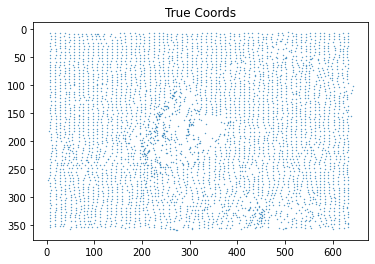

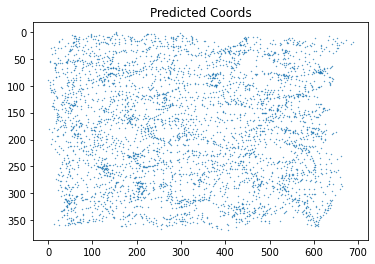

train Loss: 521.7115
----------
Epoch 130/499
----------


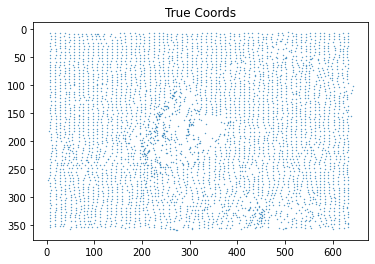

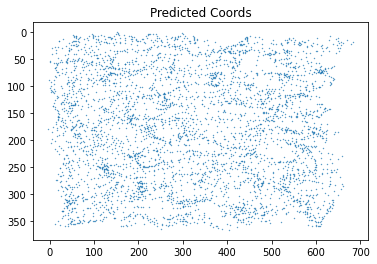

train Loss: 505.7717
----------
Epoch 140/499
----------


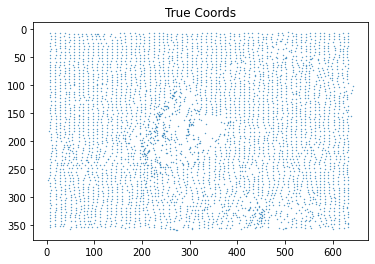

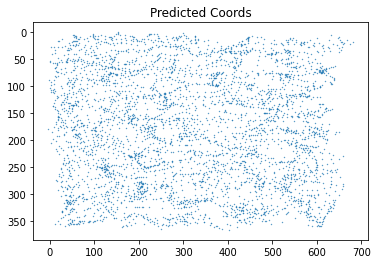

train Loss: 494.2300
----------
Epoch 150/499
----------


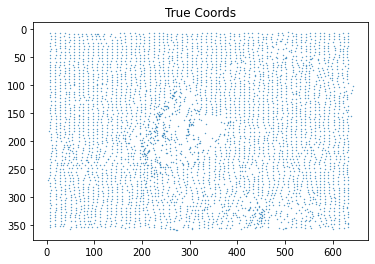

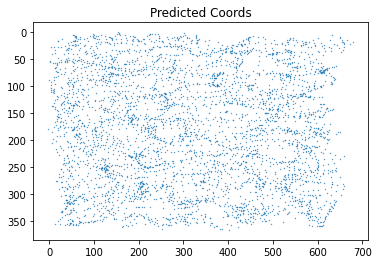

train Loss: 484.4482
----------
Epoch 160/499
----------


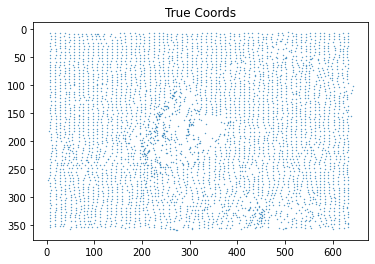

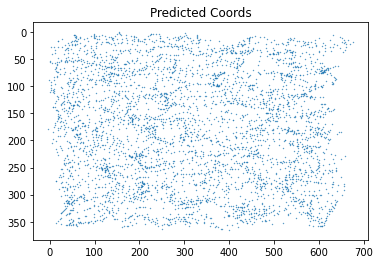

train Loss: 475.7982
----------
Epoch 170/499
----------


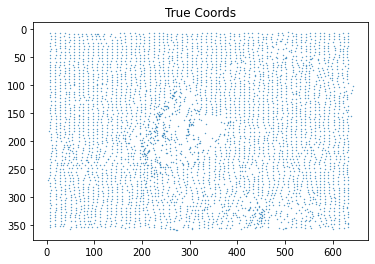

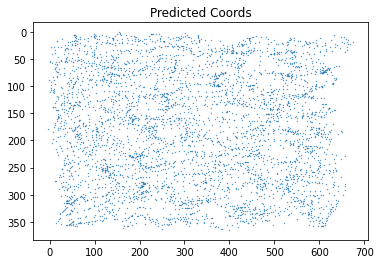

train Loss: 468.1163
----------
Epoch 180/499
----------


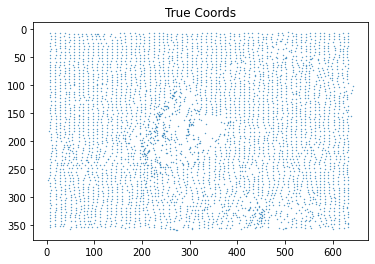

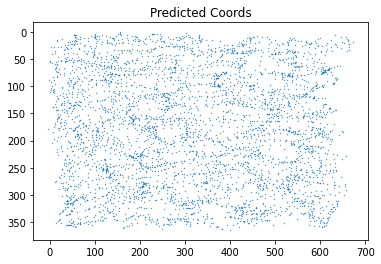

train Loss: 461.2766
----------
Epoch 190/499
----------


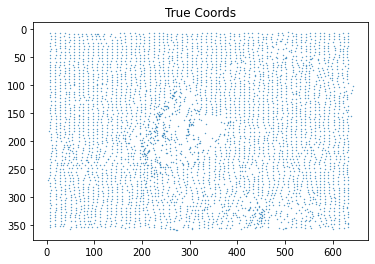

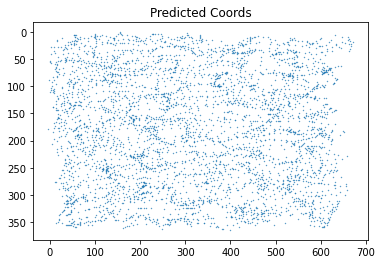

train Loss: 455.1513
----------
Epoch 200/499
----------


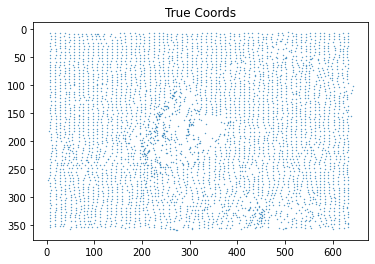

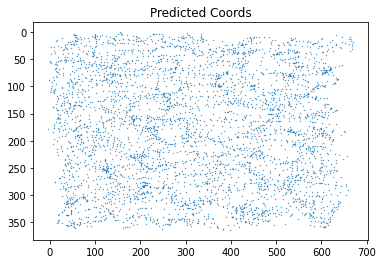

train Loss: 449.6288
----------
Epoch 210/499
----------


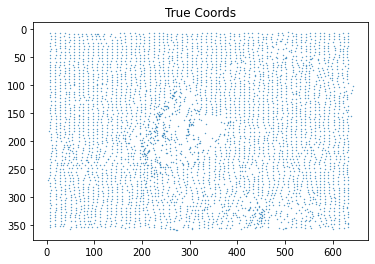

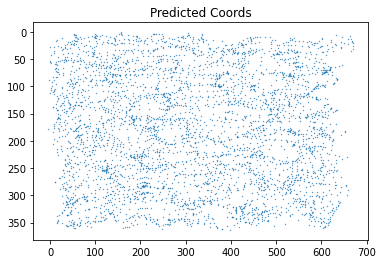

train Loss: 444.6193
----------
Epoch 220/499
----------


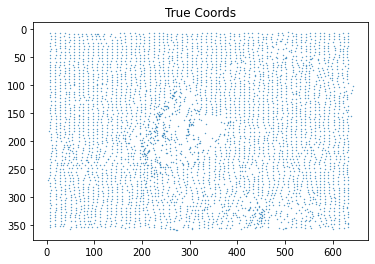

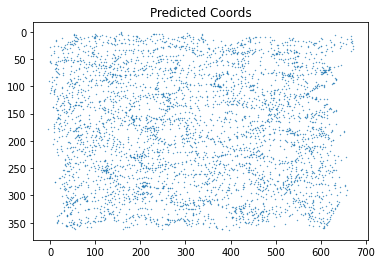

train Loss: 440.0510
----------
Epoch 230/499
----------


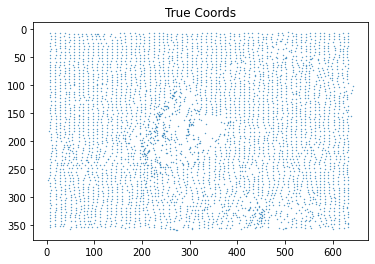

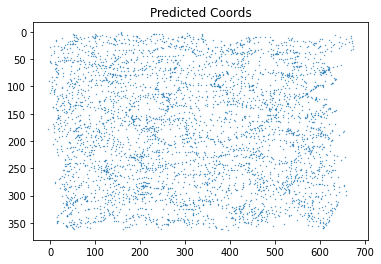

train Loss: 435.8652
----------
Epoch 240/499
----------


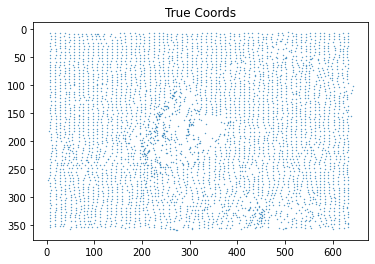

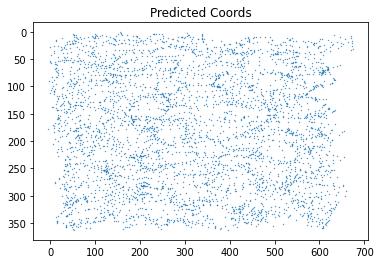

train Loss: 432.0132
----------
Epoch 250/499
----------


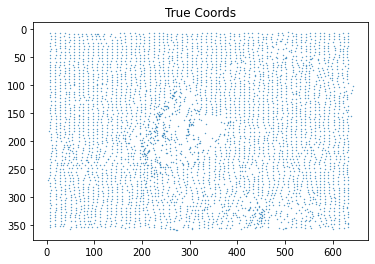

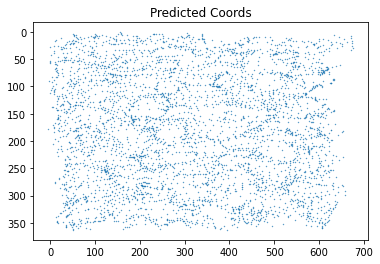

train Loss: 428.4538
----------
Epoch 260/499
----------


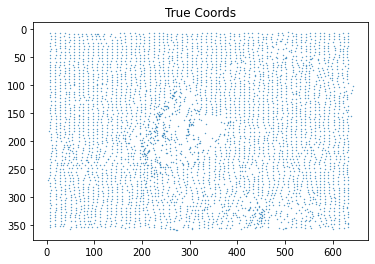

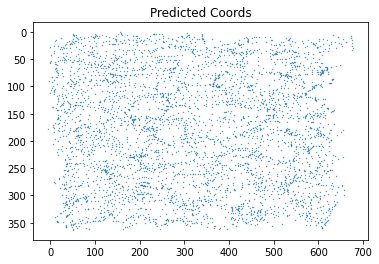

train Loss: 425.1528
----------
Epoch 270/499
----------


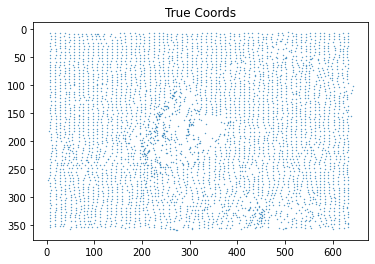

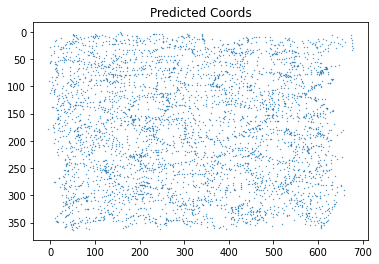

train Loss: 422.0804
----------
Epoch 280/499
----------


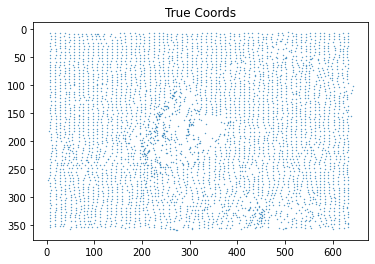

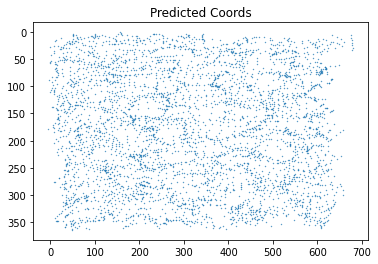

train Loss: 419.2115
----------
Epoch 290/499
----------


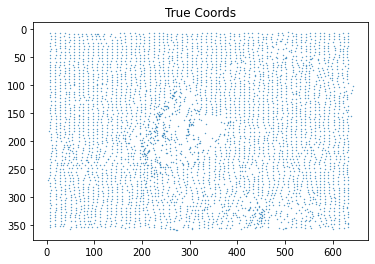

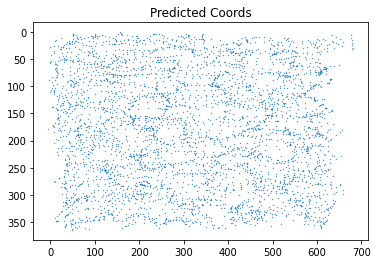

train Loss: 416.5247
----------
Epoch 300/499
----------


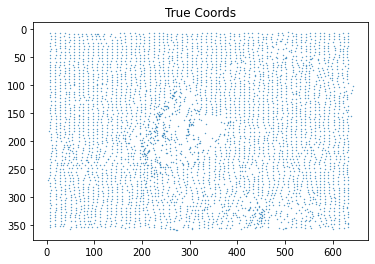

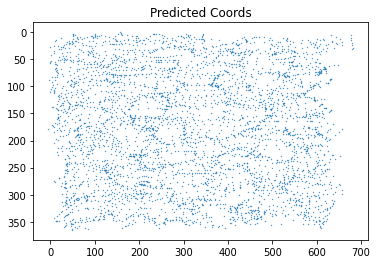

train Loss: 414.0012
----------
Epoch 310/499
----------


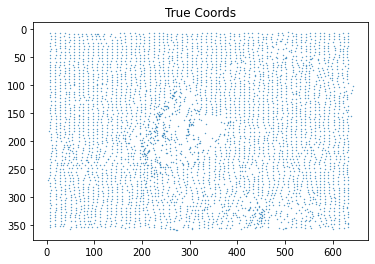

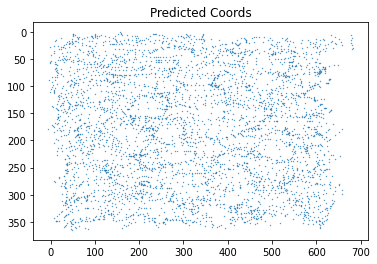

train Loss: 411.6248
----------
Epoch 320/499
----------


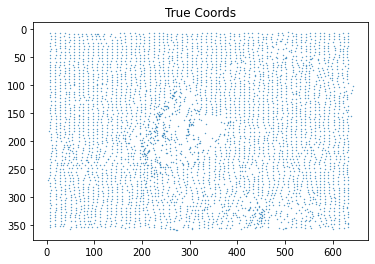

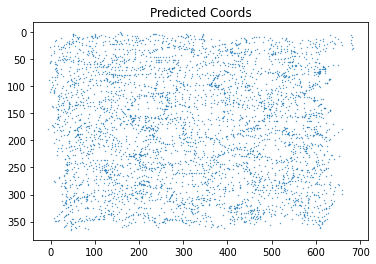

train Loss: 409.3818
----------
Epoch 330/499
----------


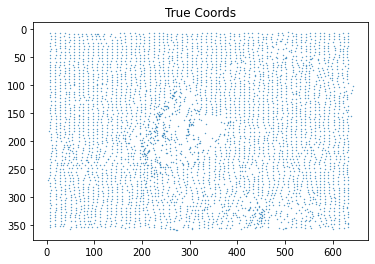

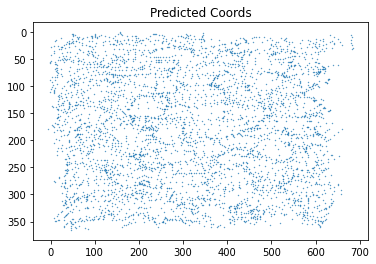

train Loss: 407.2598
----------
Epoch 340/499
----------


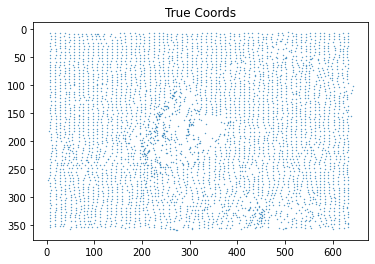

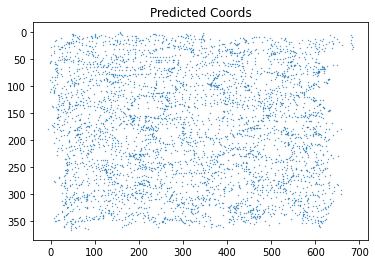

train Loss: 405.2480
----------
Epoch 350/499
----------


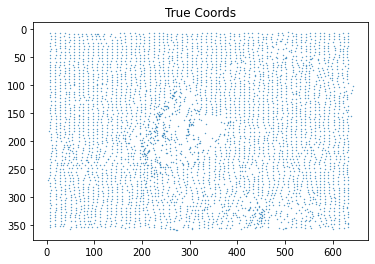

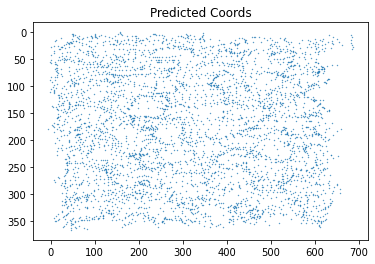

train Loss: 403.3370
----------
Epoch 360/499
----------


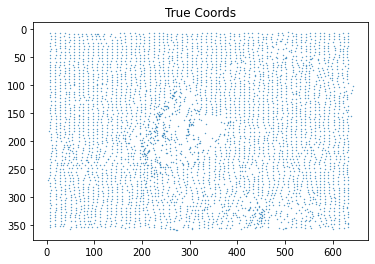

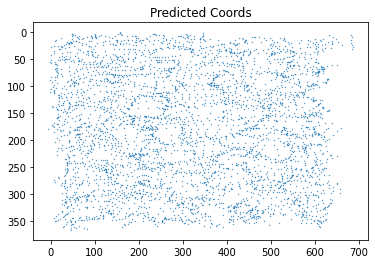

train Loss: 401.5187
----------
Epoch 370/499
----------


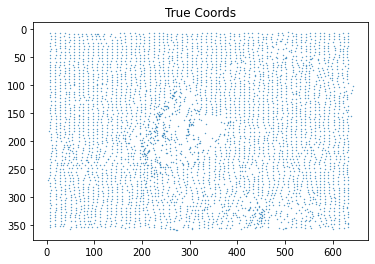

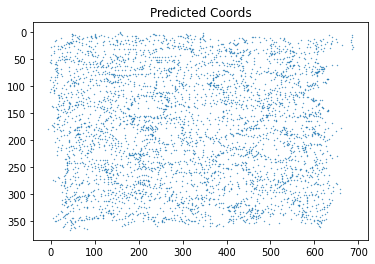

train Loss: 399.7853
----------
Epoch 380/499
----------


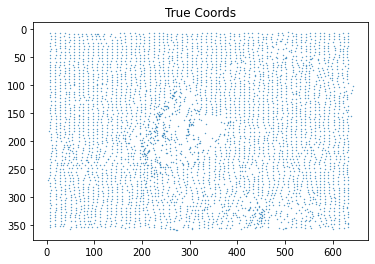

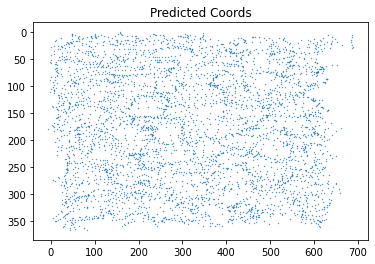

train Loss: 398.1307
----------
Epoch 390/499
----------


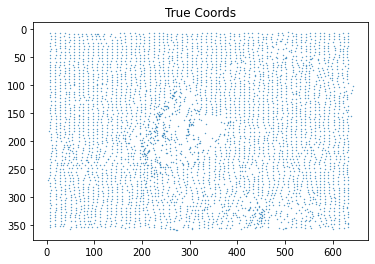

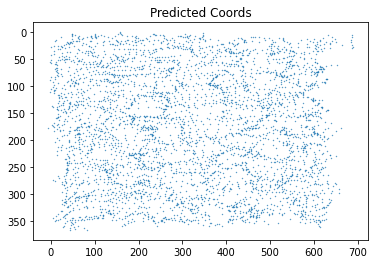

train Loss: 396.5486
----------
Epoch 400/499
----------


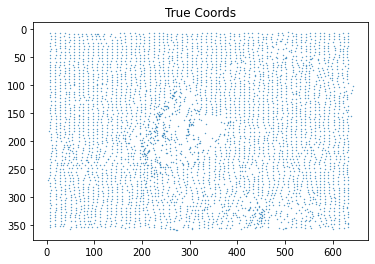

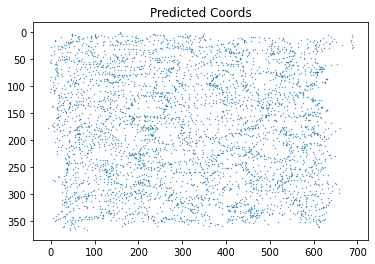

train Loss: 395.0341
----------
Epoch 410/499
----------


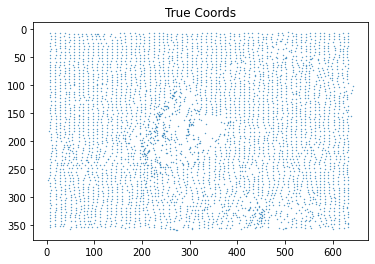

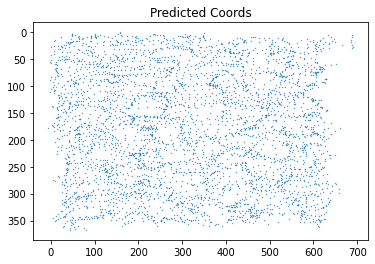

train Loss: 393.5822
----------
Epoch 420/499
----------


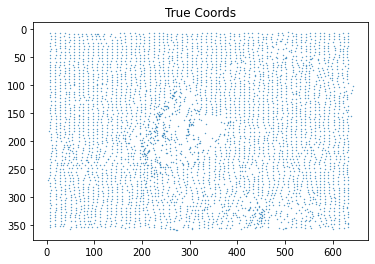

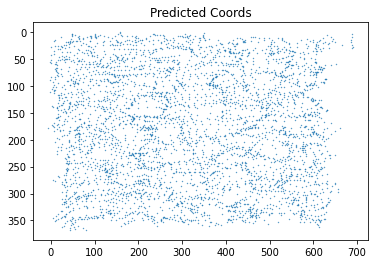

train Loss: 392.1890
----------
Epoch 430/499
----------


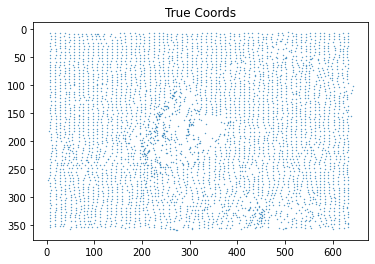

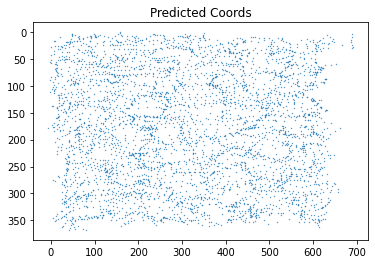

train Loss: 390.8503
----------
Epoch 440/499
----------


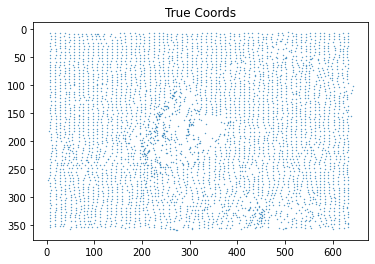

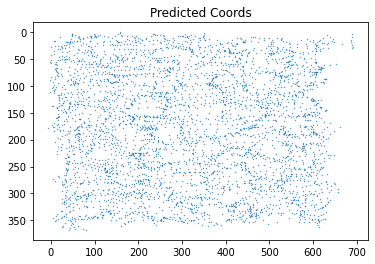

train Loss: 389.5629
----------
Epoch 450/499
----------


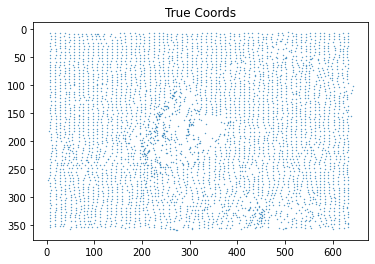

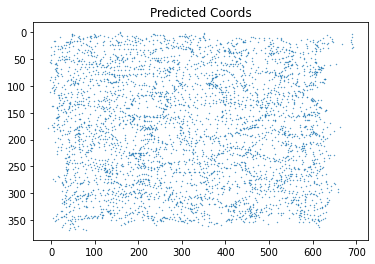

train Loss: 388.3234
----------
Epoch 460/499
----------


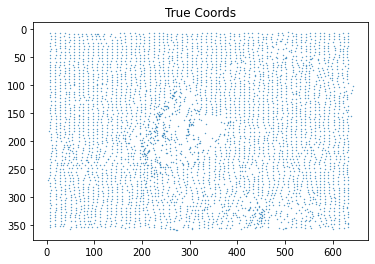

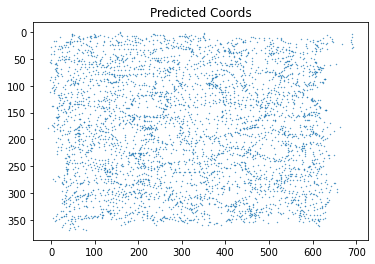

train Loss: 387.1292
----------
Epoch 470/499
----------


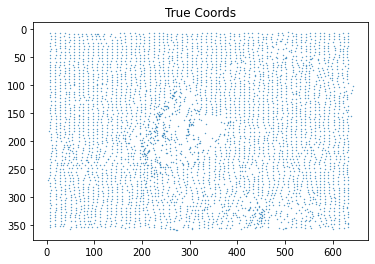

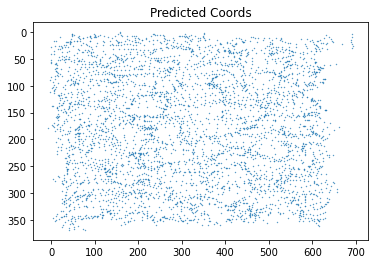

train Loss: 385.9774
----------
Epoch 480/499
----------


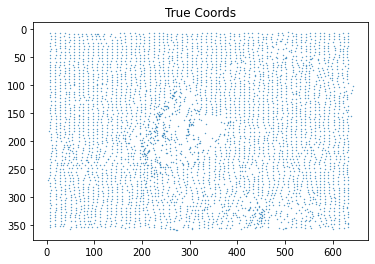

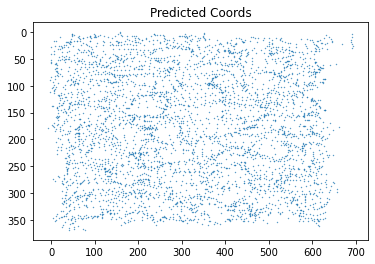

train Loss: 384.8655
----------
Epoch 490/499
----------


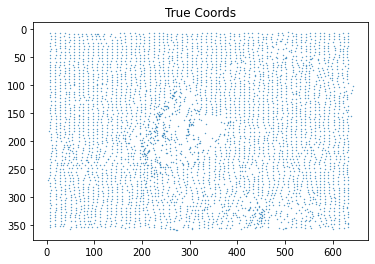

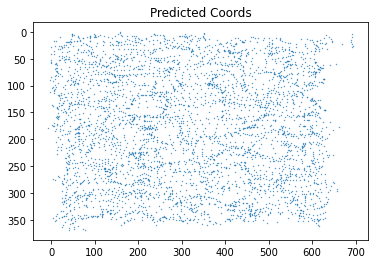

train Loss: 383.7918
----------
Epoch 499/499
----------


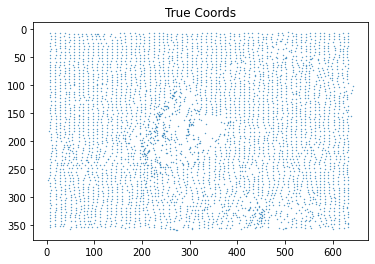

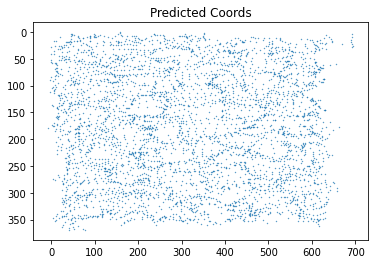

train Loss: 382.8559
Training complete in 1m 1s


In [75]:
# Define parameters
validation_split = .0
shuffle_dataset = True
random_seed = 42
batch_size = len(dataset)
num_epochs = 500

# Get train and validation dataloaders
train_loader, validation_loader = split_dataset(dataset, validation_split, batch_size, shuffle_dataset, random_seed)
dataloaders_dict = {'train': train_loader, 'val': validation_loader}

# Define optimizer
my_optimizer = optim.SGD(params_to_update, lr=0.1, momentum=0.9)

# Setup the loss
my_criterion = nn.MSELoss()

# Train and evaluate
modified_model, hist = train_model(modified_model,
                                   dataloaders_dict,
                                   my_criterion,
                                   my_optimizer,
                                   num_epochs=num_epochs)

In [11]:
for name, param in modified_model.named_parameters():
  if (name == 'classifier.4.weight') or (name == 'classifier.4.bias'):
    print(name, param)

classifier.4.weight Parameter containing:
tensor([[[[ 23.4154]],

         [[-13.8884]],

         [[ 18.5606]],

         ...,

         [[ 13.6479]],

         [[ -2.1659]],

         [[  9.5048]]],


        [[[ -5.5058]],

         [[ 14.8910]],

         [[ -8.1989]],

         ...,

         [[-13.2188]],

         [[ -1.4790]],

         [[ -5.2404]]]], device='cuda:0', requires_grad=True)
classifier.4.bias Parameter containing:
tensor([237.2251,  96.5491], device='cuda:0', requires_grad=True)
